# Optimización de portafolios

## Markowitz's mean-variance

### Planteamiento del problema

Sea $\mathbf{w} = (w_1, \ldots, w_N)$ el vector (columna) de ponderaciones del portafolio, es decir, $w_i$ representa la proporción que se tiene del activo $i$.

Dado un rendimiento deseado, $\mu^{*} \in \mathbb{R}$, se busca obtener un vector $\mathbf{w}^{*} = (w_{1}^{*}, \ldots, w_{N}^{*})$ que sea solución del siguiente problema de optimización

$$
\min_{\mathbf{w}} \sigma_{p}^{2} = \min_{\mathbf{w}} \mathbf{w}^{T} \mathbf{\Sigma} \mathbf{w}
$$

sujeto a las siguientes restricciones lineales

$$
\sum_{i = 1}^{N} w_{i} = 1
$$

y

$$
\mu_{p} = \sum_{i = 1}^{N} w_{i} \widehat{\mu_{i}} = \mu^{*}
$$

en donde $\widehat{\mu_{i}}$ es el rendimiento promedio del activo $i$.

De acuerdo al problema anterior, buscamos una combinación de ponderaciones que minimice la varianza del portafolio (y por lo tanto la volatilidad $\sigma_{p}$), invirtiendo todo nuestro capital disponible (restricción lineal 1) y a la vez obteniendo un rendimiento esperado $\mu^{*}$ (restriccion lineal 2).

El objetivo de este proyecto es resolver este problema de optimización y graficar la **frontera eficiente**.

## Datos

Se utilizarán los datos de los tres tipos de cambio `USD_MXN.csv` `EUR_MXN.csv` `GBP_MXN.csv`que vimos en clase.

## Actividades a realizar

* A partir de los archivos `csv` señalados, se deben de obtener los rendimientos logarítmicos de los precios de cierre ajustado `Adj Close` de cada archivo. Considere lo siguiente:

  * En estos archivos un valor no disponible se establece con el string `"null"`.
  
  * No se tiene la misma cantidad de información en los tres archivos.
  
  * El rendimiento logarítmico en el tiempo $t$ está dado por $\ln(P_{t} / P_{t - 1})$.
  
  * No puede calcular ninguna cantidad con una hoja de cálculo (excel) todo debe ser con python.
  

* A partir de los rendimientos logarítmicos obtenga el vector (ndarray, renglón) $\mathbf{\widehat{\mu}} = (\widehat{\mu_1}, \ldots, \widehat{\mu_N})$ en donde cada $\widehat{\mu_i}$ representa el promedio de los rendimientos logarítmicos del activo $i$. También, obtenga la matriz de varianzas y covarianzas $\mathbf{\Sigma}$. Considere lo siguiente

  * El vector $\mathbf{\widehat{\mu}}$ debe de tener rendimientos anualizados, es decir cada entrada $\mu_{i}$ debe de ir multiplicada por $252$.

```python
import numpy as np
import pandas as pd
help(np.cov) #CUIDADO CON EL PARÁMETRO rowvar
#Los Dataframe tienen el método cov implementado
help(pd.DataFrame.cov)
#Si X es un data frame con sólo columnas
#numéricas, entonces
#X.cov() regresa la matriz de varianzas y covarianzas
```

* Programe una función para calcular la varianza del portafolio $\sigma_{p}^{2} = \mathbf{w}^{T} \mathbf{\Sigma} \mathbf{w}$, esta es la función objetivo de nuestro problema de optimización.

  * Recuerde que con **numpy** puede realizar la multiplicación de matrices (ndarrays) con `np.matmul` o con el símbolo `@`.
  
  * La varianza debe de regresarse anualizada, es decir, debe de calcular $ 252 * \mathbf{w}^{T} \mathbf{\Sigma} \mathbf{w}$.

* Resuelva el problema de optimización utilizando la función `minimize` del módulo `scipy.optimize` para distintos valores valores de $\mu^{*}$, estos rendimientos objetivo (anualizados) estarán dados por

```python
mu_0 = np.linspace(0.02, 0.11, 100)
```

* Grafique la frontera eficiente, el eje X será la volatilidad (anualizada) del portafolio, $\sigma_{p}$, la cual se obtiene al aplicar la raíz cuadrada del valor regresado por la función `minimize`. El eje Y será el rendimiento esperado $\mu^{*}$ asociado con esa volatilidad.

# FECHA DE ENTREGA

Ya que tengo que entregar las calificaciones el día 30 de junio, la entrega de este proyecto es **a más tardar** el día sábado 27 de junio a las 11:59 horas.

**ESTA VEZ NO HABRÁ PRORROGA**
  

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds
from numpy import linalg
import matplotlib.pyplot as plt

In [2]:
#NA aparece como null
rutas = ['../datos/USD_MXN.csv',
         '../datos/EUR_MXN.csv',
         '../datos/GBP_MXN.csv']

#diccionario que alamcenará las tablas
tablas = {}

#Lee datos y realiza
#un poco de preprocesamiento
for ruta in rutas:
    #Crea la llave
    #del diccionario, e.g., USD_MXN
    llave = ruta.split('.csv') # ['../datos/GBP_MXN.', '']
    llave = llave[0].split('/') # ['..', 'datos', 'GBP_MXN']
    llave = llave[-1] # GBP_MXN
    
    #Abre el archivo
    tablas[llave] = pd.read_csv(ruta, na_values = ['null'])
    
    #QUita NaN
    tablas[llave].dropna(inplace = True)
    
    #Renombra la columna Adj Close
    col_name = llave + '_Close'
    tablas[llave].rename(columns = {'Adj Close':col_name},
                        inplace = True)
    
    #Elimina Columnas que no se usarán
    del tablas[llave]['Open']
    del tablas[llave]['High']
    del tablas[llave]['Low']
    del tablas[llave]['Close']
    del tablas[llave]['Volume']

In [3]:
#Crea un data frame que combina
#las tablas

#Las primeras dos tablas se unen de forma manual
llaves = list(tablas.keys())

precios = pd.merge(tablas[llaves[0]], tablas[llaves[1]],
                  on = 'Date')

#Las otras tablas se unen de manera iterativa
for i in range(2, len(llaves)):
    llave = llaves[i]
    precios = pd.merge(precios, tablas[llave],
                      on = 'Date')

#No me conviene conservar la columna Date
#así que la copio y la elimino del dataframe
fechas = precios['Date'].copy()
del precios['Date']
precios

,USD_MXN_Close,EUR_MXN_Close,GBP_MXN_Close
0,15.395500,17.272200,23.829800
1,15.437300,17.281900,23.967899
2,15.388000,17.403799,24.071800
3,15.255900,17.296600,24.062799
4,15.331400,17.340000,24.171801
...,...,...,...
1278,21.474899,24.307199,27.324900
1279,21.473000,24.288601,27.359200
1280,21.887400,24.801701,27.818300
1281,21.976999,24.976400,27.930099


In [4]:
#Se calculan los rendimientos (logarítmicos)
n_obs = precios.shape[0]

#Precios en t
pt = precios.iloc[1:n_obs, :].reset_index(drop = True)

#Precios en t - 1
pt_1 = precios.iloc[0:(n_obs - 1), :].reset_index(drop = True)

#Rendimientos
rendimientos = np.log(pt / pt_1)
rendimientos

,USD_MXN_Close,EUR_MXN_Close,GBP_MXN_Close
0,0.002711,0.000561,0.005778
1,-0.003199,0.007029,0.004326
2,-0.008622,-0.006179,-0.000374
3,0.004937,0.002506,0.004520
4,0.000646,0.005234,0.006926
...,...,...,...
1277,-0.019716,-0.021220,-0.010485
1278,-0.000088,-0.000765,0.001254
1279,0.019115,0.020905,0.016641
1280,0.004085,0.007019,0.004011


In [5]:
#Matriz de varianzas y covarianzas
#En un arreglo de numpy
#CUIDADO CON EL PARÁMETRO rowvar
#Otra forma rendimientos.cov().to_numpy()
mat_cov = np.cov(rendimientos, rowvar = False)

#Vector mu (rendimientos promedios)
mu = np.array(rendimientos.mean(axis = 0)) * 252

#Vector de desviaciones estándar
desv_est = np.array(rendimientos.std(axis = 0)) * np.sqrt(252)

In [6]:
def calcula_varianza_port(pesos, *args):
    '''
    Función para calcular la varianza de un portafolio
    
    ENTRADA
    pesos: ndarray (renglon) de números con la ponderación de cada
    activo
    
    *args: tupla con tiene los siguientes elementos
    
    args[0]: ndarray (renglón) de números que representa
    el vector columna con los rendimientos esperados
    
    args[1]: ndarray (matriz) que representa la matriz
    de varianzas y covarianzas
    
    SALIDA
    float no negativo
    '''
    #extrae la matriz de covarianzas
    mat_cov = args[0]
    
    #varianza es un ndarray
    #por eso se hace cast a float
    #varianza = pesos.transpose() @ mat_cov @ pesos
    varianza = pesos @ mat_cov @ pesos.transpose()
    
    return float(varianza * 252)

In [7]:
#FRONTERA EFICIENTE

#restricción de suma de pesos
n_activos = rendimientos.shape[1]
unos = np.ones(n_activos)
rest_suma = LinearConstraint(unos, lb = 1, ub = 1)

#rendimientos deseados
mu_0 = np.linspace(0.02, 0.11, 100)

#desviación estándar en el óptimo
desv_est_op = np.zeros(len(mu_0))

#cotas
#Cambiar cotas para
#obtener una solución
#realista (pesos en (-1,1) o en (0, 1))
cotas = Bounds(lb = [-np.inf] * n_activos,
              ub = [np.inf] * n_activos)

#Pesos iniciales
pesos = np.array([1 / n_activos] * n_activos)

#Para localizar los casos
#en los que el proceso de 
#optimización encuentra una
#solución
idx_exito = []

#Para almacenar las ponderaciones
#óptimas
pond_opt = []
for i in range(len(mu_0)):
    
    #auxiliar para crear la tabla
    #con las ponderaciones óptimas
    aux_renglon = []
    
    #restricción de rendimiento deseado
    rest_rend = LinearConstraint(mu,
                                 lb = mu_0[i],
                                 ub = mu_0[i])
    
    #agrupa restricciones
    rest = [rest_suma, rest_rend]
    
    #busca solución
    solucion = minimize(calcula_varianza_port, pesos, \
                   method = 'SLSQP', \
                    args = mat_cov, \
                    constraints = rest, \
                       bounds=cotas)
    
    if solucion.success:
        w_opt = solucion.x
        aux_renglon.extend(w_opt)
        aux_renglon.extend([mu_0[i]])
        desv_est_op[i] = np.sqrt(calcula_varianza_port(w_opt, mat_cov))
        aux_renglon.extend([desv_est_op[i]])
        pond_opt.append(aux_renglon)
        idx_exito.append(i)

#Dataframe con las ponderaciones
columnas = list(rendimientos.columns) + \
['Rend_Esperado', 'Desv_Est']
pond_opt = pd.DataFrame(pond_opt, 
                       columns = columnas )
pond_opt

,USD_MXN_Close,EUR_MXN_Close,GBP_MXN_Close,Rend_Esperado,Desv_Est
0,0.370927,-0.643956,1.273029,0.020000,0.144598
1,0.373853,-0.625491,1.251638,0.020909,0.143511
2,0.376778,-0.607026,1.230247,0.021818,0.142441
3,0.379704,-0.588561,1.208856,0.022727,0.141387
4,0.382630,-0.570095,1.187466,0.023636,0.140351
...,...,...,...,...,...
95,0.648871,1.110227,-0.759098,0.106364,0.151230
96,0.651797,1.128692,-0.780489,0.107273,0.152421
97,0.654722,1.147157,-0.801879,0.108182,0.153626
98,0.657648,1.165622,-0.823270,0.109091,0.154844


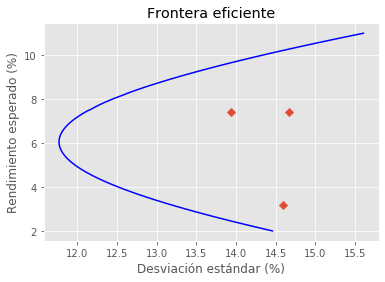

In [8]:
plt.style.use('ggplot')
plt.plot( 100 * desv_est_op[(list(idx_exito))],\
         100 * mu_0[(list(idx_exito))], '-b')

plt.scatter(100 * desv_est,  100 * mu, marker = 'D')
plt.xlabel('Desviación estándar (%)')
plt.ylabel('Rendimiento esperado (%)')
plt.title('Frontera eficiente')
plt.savefig('frontera-eficiente.png', dpi = 500, bbox_inches = 'tight')
plt.show()

In [9]:
#Obtiene los casos en los que
#las ponderaciones se encuentran
#dentro del intervalo (lim_inf, lim_sup)

#Sólo se queda con las columnas
#de las ponderaciones
col_pond = list(pond_opt.columns)[0:n_activos]

lim_inf = -1
lim_sup = 1 
exito = []

#Por cada columna obtiene
#las ponderaciones que se encuentran
#dentro de los límites
for col in col_pond:
    
    #Series con valores booleanos
    mayor = pond_opt.loc[:, col] >= lim_inf
    menor = pond_opt.loc[:, col] <= lim_sup
    
    #Aplica AND entrada por entrada
    #a la columna correspondiente
    exito.append(mayor & menor)


#Ubica en que casos todas las ponderaciones
#se encuentran dentro de los límites
#Las primeras dos columnas se hacen
#de manera manual, después con el for
idx_exito = exito[0] & exito[1]
for i in range(2, len(exito)):
    idx_exito = idx_exito & exito[i]

pond_opt_filtrado = pond_opt.loc[idx_exito, :].copy()
pond_opt_filtrado

,USD_MXN_Close,EUR_MXN_Close,GBP_MXN_Close,Rend_Esperado,Desv_Est
13,0.408961,-0.403910,0.994948,0.031818,0.131875
14,0.411887,-0.385445,0.973558,0.032727,0.131035
15,0.414813,-0.366980,0.952167,0.033636,0.130217
16,0.417739,-0.348514,0.930776,0.034545,0.129421
17,0.420664,-0.330049,0.909385,0.035455,0.128647
...,...,...,...,...,...
85,0.619614,0.925576,-0.545190,0.097273,0.140161
86,0.622539,0.944041,-0.566580,0.098182,0.141194
87,0.625465,0.962506,-0.587971,0.099091,0.142244
88,0.628391,0.980971,-0.609362,0.100000,0.143311


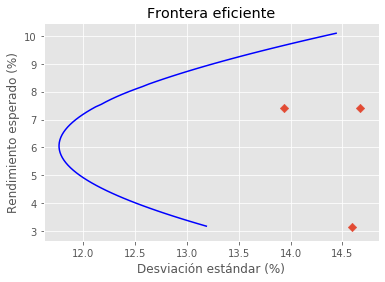

In [10]:
plt.plot( 100 * pond_opt_filtrado['Desv_Est'] ,\
         100 * pond_opt_filtrado['Rend_Esperado'], '-b')
plt.scatter(100 * desv_est,  100 * mu, marker = 'D')
plt.xlabel('Desviación estándar (%)')
plt.ylabel('Rendimiento esperado (%)')
plt.title('Frontera eficiente')
plt.show()